#  Прогнозирование заказов такси

В нашем распоряжении исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 
**Задача:** построить модель для такого предсказания.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Проверим данные на наличие пропусков и дубликатов сейчас, чтобы далее иметь возможность сделать дату индексом таблицы.

In [3]:
df.duplicated().sum()

0

In [4]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

Ни дубликатов, ни пропусков не обнаружено.

In [5]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col='datetime')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Типы данных верные.

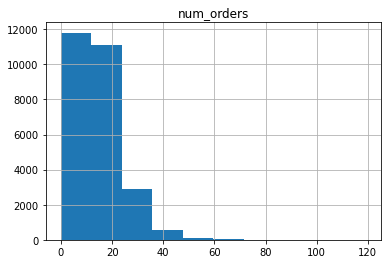

In [6]:
df.hist()
plt.show()

In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
df.index.is_monotonic

True

Гистограмма выглядит хорошо, данные упорядочены по индексу.

Ресемплируем данные по одному часу и вычислим сумму для каждого часа.

In [9]:
# Ресемплирование
df = df.resample('1H').sum()

In [10]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Исследуем данные на тренды и сезонность.

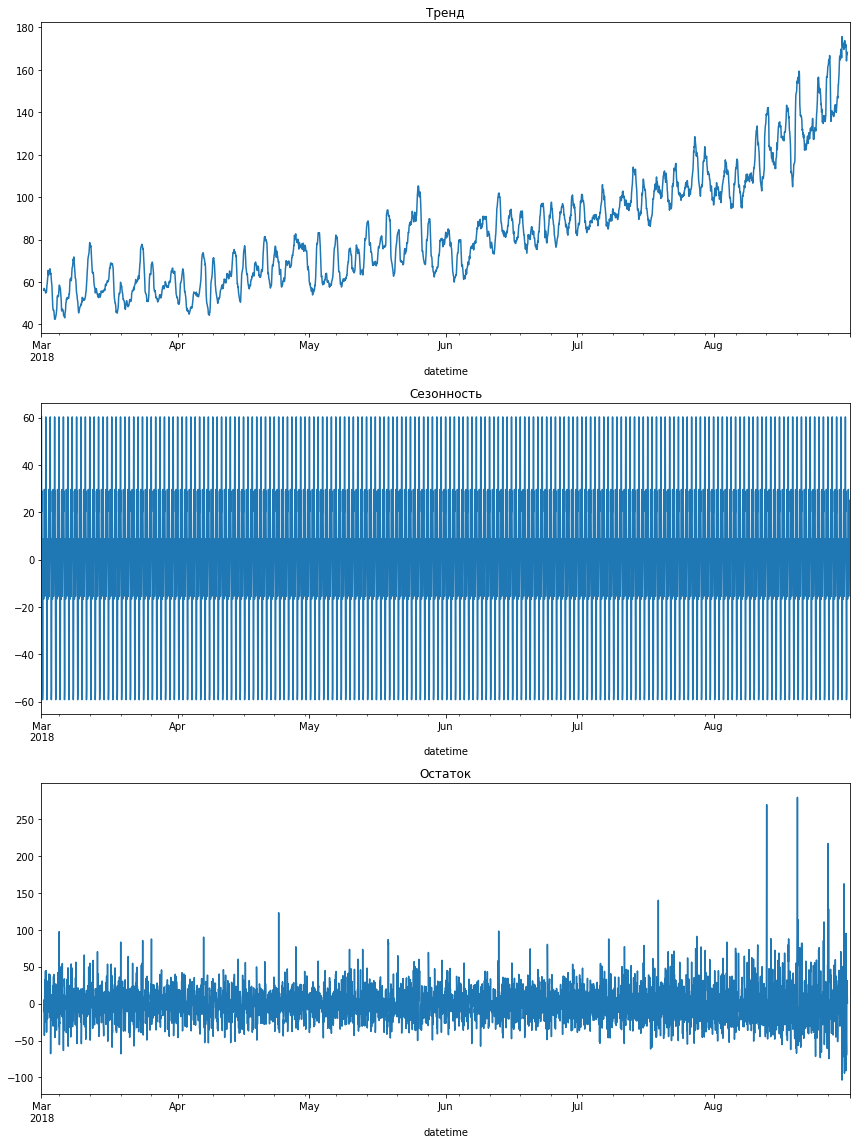

In [11]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 16))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Согласно графику тренда, количество заказов такси увеличивается в течение всего временного периода, предоставленного к исследованию (с марта по сентябрь 2018 года). Наиболее сильно заметен рост в летний период. Причиной может являться отпускной сезон.

По графику сезонности сложно что-либо понять, рассмотрим одну из неделю для более детального изучения.

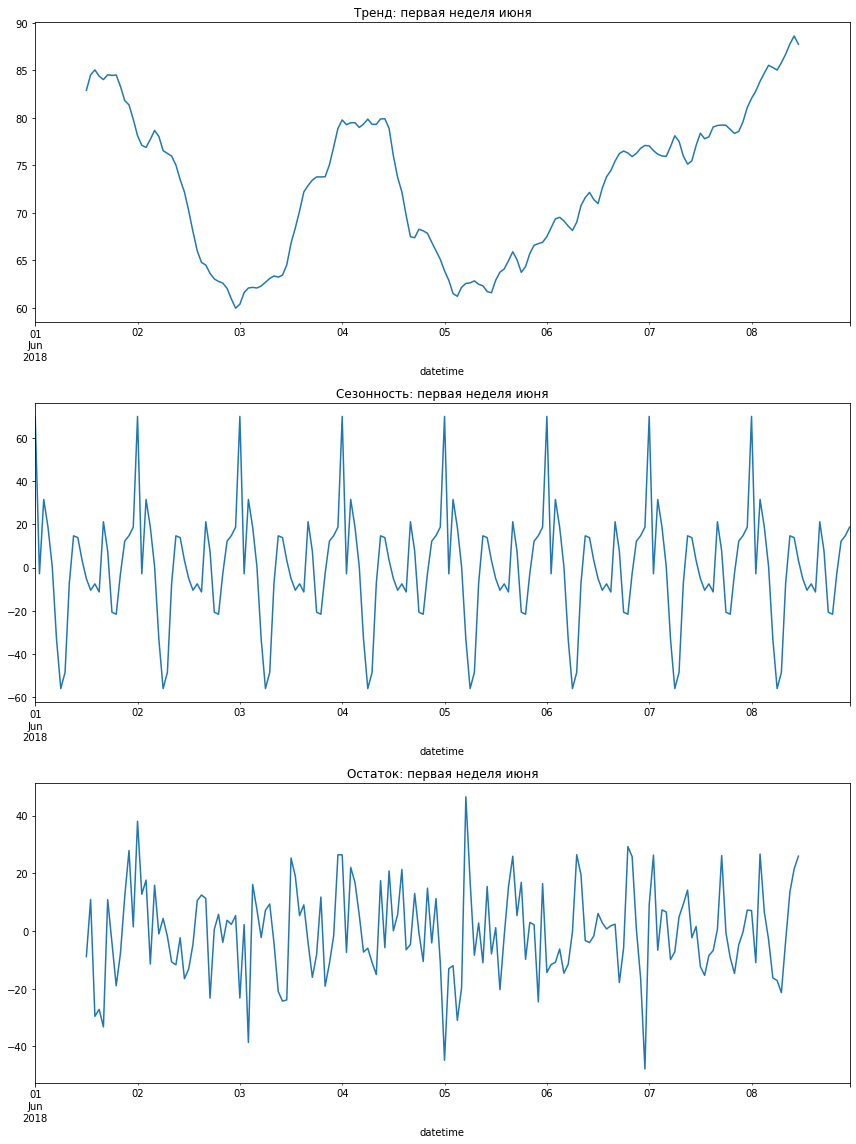

In [12]:
decomposed_week = seasonal_decompose(df['2018-06-01':'2018-06-8'])

plt.figure(figsize=(12, 16))

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Тренд: первая неделя июня')

plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Сезонность: первая неделя июня')

plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.title('Остаток: первая неделя июня')
plt.tight_layout()

На таком масштабе про тренд ничего сказать не получится - слишком маленький масштаб. Зато на графике сезонности теперь можно разглядеть закономерность, рассмотрим ее более детально.

Text(0.5, 1.0, 'Сезонность (1-2 июня)')

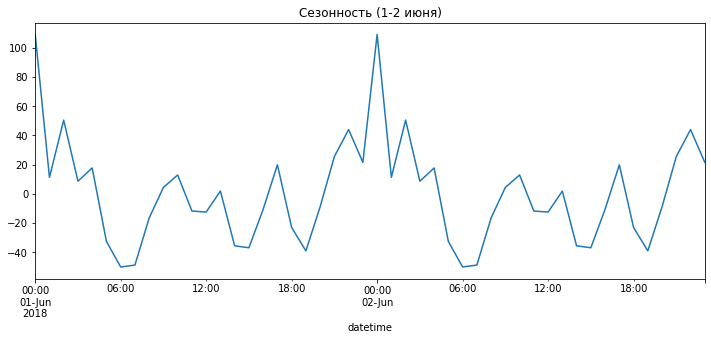

In [13]:
decomposed_3d = seasonal_decompose(df['2018-06-01':'2018-06-2'])

plt.figure(figsize=(12, 16))

plt.subplot(312)

decomposed_3d.seasonal.plot(ax=plt.gca())
plt.title('Сезонность (1-2 июня)')

Пик заказов приходится на полночь, а минимум - на 6-7 утра.

## Обучение

In [14]:
def RMSE(target,predict):
    return mean_squared_error(target, predict) ** 0.5

Создадим признаки для дальнейшего обучения модели.

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    df = df.copy(deep=True)
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [16]:
df_feat = make_features(df, 24, 24)
df_feat.sample(5)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-14 13:00:00,64,14,5,74.0,107.0,102.0,139.0,74.0,40.0,34.0,...,137.0,97.0,140.0,105.0,130.0,112.0,78.0,112.0,107.0,112.833333
2018-07-16 06:00:00,15,16,0,64.0,187.0,136.0,126.0,109.0,224.0,100.0,...,116.0,73.0,108.0,62.0,61.0,92.0,73.0,36.0,48.0,101.750000
2018-08-27 08:00:00,131,27,0,37.0,31.0,62.0,295.0,208.0,408.0,222.0,...,143.0,142.0,164.0,89.0,151.0,96.0,136.0,147.0,124.0,156.333333
2018-05-14 17:00:00,119,14,0,116.0,93.0,62.0,81.0,58.0,92.0,123.0,...,106.0,158.0,130.0,88.0,101.0,94.0,70.0,48.0,117.0,87.875000
2018-08-13 17:00:00,152,13,0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,...,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,139.166667


In [17]:
train, test = train_test_split(df_feat, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()

train, valid = train_test_split(train, shuffle=False, test_size=0.1)
valid = valid.dropna()

features_train = train.drop(['num_orders'],axis=1)
features_valid = valid.drop(['num_orders'],axis=1)
features_test = test.drop(['num_orders'],axis=1)

target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(3555, 27)
(395, 27)
(442, 27)


### Cлучайный лес

In [18]:
%%time

tss = TimeSeriesSplit(n_splits = 5)
RMSE_score = make_scorer(RMSE, greater_is_better=False)

model_forest = RandomForestRegressor(random_state=12345)
params_forest = {'n_estimators':range(110,150,10),
                 'max_depth':range(20,50,10)}

grid_forest = GridSearchCV(model_forest, params_forest, cv=tss, scoring=RMSE_score, n_jobs=-1)
grid_forest.fit(features_train, target_train)

prediction_forest = grid_forest.predict(features_valid)

print('Лучшие параметры модели:', grid_forest.best_params_)
print('RMSE модели случайный лес:', RMSE(target_valid, prediction_forest))

Лучшие параметры модели: {'max_depth': 40, 'n_estimators': 140}
RMSE модели случайный лес: 32.86888396638311
CPU times: user 2min 55s, sys: 473 ms, total: 2min 55s
Wall time: 2min 55s


### CatBoost

In [19]:
%%time

model_cat = CatBoostRegressor(iterations=100, verbose=False, random_state=12345)
params_cat = {'learning_rate':[0.1, 0.15], 
                    'depth':[10, 15]} 

grid_cat = GridSearchCV(model_cat, params_cat, cv=tss, scoring = RMSE_score, n_jobs=-1)
grid_cat.fit(features_train, target_train)

prediction_cat = grid_cat.predict(features_valid)

print('Лучшие параметры модели CatBoost:', grid_cat.best_params_)
print('RMSE модели CatBoost:', RMSE(target_valid, prediction_cat))

Лучшие параметры модели CatBoost: {'depth': 10, 'learning_rate': 0.1}
RMSE модели CatBoost: 33.28229348702087
CPU times: user 28min 54s, sys: 19min 12s, total: 48min 6s
Wall time: 48min 22s


### LightGBM

In [30]:
%%time

model_lgbm = LGBMRegressor(random_state=12345)
params_lgbm = {'n_estimators':[100, 120], 
                  'num_leaves':[10, 15]} 

grid_lgbm = GridSearchCV(model_lgbm, params_lgbm, cv=tss, scoring = RMSE_score, n_jobs=-1)
grid_lgbm.fit (features_train, target_train)

prediction_lgbm = grid_lgbm.predict(features_valid)

print('Лучшие параметры модели LightGBM:', grid_lgbm.best_params_)
print('RMSE модели LightGBM:', RMSE(target_valid, prediction_lgbm))

Лучшие параметры модели LightGBM: {'n_estimators': 100, 'num_leaves': 10}
RMSE модели LightGBM: 32.96420609285422
CPU times: user 2min 1s, sys: 0 ns, total: 2min 1s
Wall time: 2min 2s


### Константная модель

In [21]:
model_mean = DummyRegressor(strategy="mean")
model_mean.fit(features_train, target_train)
prediction_mean = model_mean.predict(features_valid)
print('RMSE константной модели:', RMSE(target_valid, prediction_mean))

RMSE константной модели: 57.84391361982832


### Анализ моделей

In [31]:
models = {'Модель':['RandomForest', 'CatBoost','LGBMRegressor','Mean'],
         'RMSE':['32.87','33.28','32.96','57.84']}

display(pd.DataFrame.from_dict(models))

,Модель,RMSE
0,RandomForest,32.87
1,CatBoost,33.28
2,LGBMRegressor,32.96
3,Mean,57.84


Все модели показали результат RMSE лучше, чем константная модель, что говорит об адекватности всех представленных моделей.
Наилучшей считается модель с минимальным значением RMSE. Модель с наилучшим результатом - RandomForest. Проверим эту модель на тестовой выборке.

## Тестирование

In [32]:
model_forest = RandomForestRegressor(random_state=12345, max_depth=40, n_estimators=140)
model_forest.fit(features_train, target_train)
prediction_forest = model_forest.predict(features_test)

print('RMSE модели RandomForest на тестовой выборке:', RMSE(target_test, prediction_forest))

RMSE модели RandomForest на тестовой выборке: 47.23109348536071


Проверим как соотносятся тестовые данные с предсказанными.

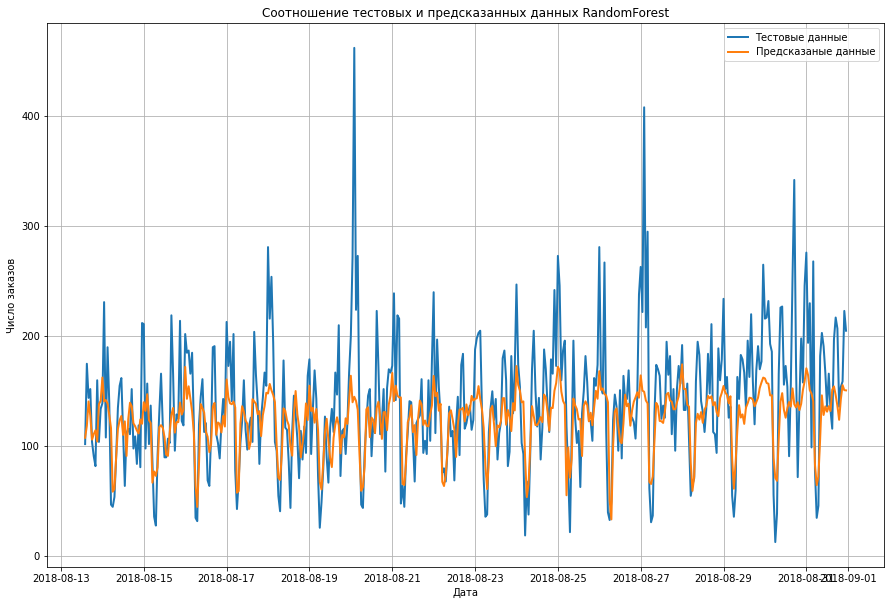

In [33]:
plt.figure(figsize=(15, 10))

plt.plot (features_test.index, target_test, label='Тестовые данные', linewidth = 2)
plt.plot (features_test.index, prediction_forest, label='Предсказаные данные', linewidth = 2)

plt.legend()
plt.title('Соотношение тестовых и предсказанных данных RandomForest')
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.grid(True)
plt.show()

Можно заметить, что тестовые и предсказанные данные в целом достаточно хорошо соотносятся, за исключением резких пиков.

## Вывод

В ходе работы над проектом была проведена предобработка данных:
- Столбцы проверены на наличие дубликатов и пропусков
- Проведено упорядочивание данных по дате  
- Данные ресемплированы по одному часу
- Созданы дополнительные признаки данных: день, день недели

Данные исследованы на тренды и сезонность.

Согласно графику тренда, количество заказов такси увеличивается в течение всего временного периода, предоставленного к исследованию (с марта по сентябрь 2018 года). Наиболее сильно заметен рост в летний период. Причиной может являться отпускной сезон.

Имеется сезонность - повторяющиеся закономерности на протяжении каждого дня: пик заказов приходится на полночь, а минимум - на 6-7 утра.

Для исслеования использовались следующие модели:

- RandomForest
- CatBoost 
- LGBMRegressor 
- Константная модель

Все модели показали на тренировочной выборке результат RMSE лучше, чем константная модель, что говорит об адекватности всех представленных моделей. Модель с наилучшим результатом RMSE - RandomForest.


RMSE моделей на тренировочной выборке
- RandomForest (32.87)
- CatBoost (33.28)
- LGBMRegressor (32.96)
- Константная модель (57.84)

RMSE лучшей модели на тестовой выборке
- RandomForest (47.23)